# Machine Learning

1. Statistcs
2. SVM model
3. visulization

In [1]:
import os
import glob
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import math
import seaborn as sns
from scipy.stats import levene, shapiro, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterSampler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

## Data preprocess
1. train test split
2. Standardization

In [2]:
# Load data
path = 'path'
H_data = pd.read_csv(path + 'HighFeature.csv')
L_data = pd.read_csv(path + 'LowFeature.csv')
H_data['Label'] = 1
L_data['Label'] = 0

In [4]:
# train test split
XH_train, XH_test, yH_train, yH_test = train_test_split(H_data.drop(columns='Label'), H_data['Label'], test_size=0.3, random_state=1)
XL_train, XL_test, yL_train, yL_test = train_test_split(L_data.drop(columns='Label'), L_data['Label'], test_size=0.3, random_state=1)

## Statistics
- Check if variables are significant different in two groups
1. shapiro (檢查是否為常態分布)
2. Levene (檢查資料是否為相同變異數)
3. two-tailed t-test

In [5]:
good_feature = []
p_values = []
for feature in XH_train.columns:
    sat, p_value_H = shapiro(XH_train[feature])
    sat, p_value_L = shapiro(XL_train[feature])
    if p_value_H>0.05 and p_value_L>0.05:
        sat, p_value = levene(XH_train[feature], XL_train[feature])
        if p_value > 0.05:
            sat, p_value = ttest_ind(XH_train[feature], XL_train[feature], equal_var = True)
            if p_value <0.05:
                good_feature.append(feature)
                p_values.append(p_value)

print(dict(zip(good_feature, p_values)))

{'CH2_Oxy_Base_Trail_Diff': 0.027447893069354325, 'CH3_Oxy_Base_Activation': 0.027373890108082676, 'CH2_Oxy_Trail_Slope': 0.00879794634686464, 'CH3_Oxy_Base_Std': 0.02662826067954871, 'CH3_Oxy_Base_Trail_Std_Diff': 0.04199427730340064, 'CH2_HbT_Trail_Feedback_Std_Diff': 0.025565592903493188}


# SVM

In [68]:
# ParameterSampler
param_grid={"gamma":[0.001, 0.01, 0.1, 1], "C":[0.01, 0.1, 1, 10, 100]}
pam = ParameterSampler(param_grid, n_iter=10000)

{'gamma': 0.001, 'C': 0.01}
{'gamma': 0.01, 'C': 0.01}
{'gamma': 0.1, 'C': 0.01}
{'gamma': 1, 'C': 0.01}
{'gamma': 0.001, 'C': 0.1}
{'gamma': 0.01, 'C': 0.1}
{'gamma': 0.1, 'C': 0.1}
{'gamma': 1, 'C': 0.1}
{'gamma': 0.001, 'C': 1}
{'gamma': 0.01, 'C': 1}
{'gamma': 0.1, 'C': 1}
{'gamma': 1, 'C': 1}
{'gamma': 0.001, 'C': 10}
{'gamma': 0.01, 'C': 10}
{'gamma': 0.1, 'C': 10}
{'gamma': 1, 'C': 10}
{'gamma': 0.001, 'C': 100}
{'gamma': 0.01, 'C': 100}
{'gamma': 0.1, 'C': 100}
{'gamma': 1, 'C': 100}


c:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 20 is smaller than n_iter=10000. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [83]:
train_acc = []
test_acc = []
param_list = []

XH_train, XH_test, yH_train, yH_test = train_test_split(H_data[['CH2_HbT_Trail_Feedback_Std_Diff', 'CH2_Oxy_Trail_Slope']], H_data['Label'], test_size=0.3, random_state=i)
XL_train, XL_test, yL_train, yL_test = train_test_split(L_data[['CH2_HbT_Trail_Feedback_Std_Diff', 'CH2_Oxy_Trail_Slope']], L_data['Label'], test_size=0.3, random_state=i)
X_train = pd.concat([XH_train, XL_train])
X_test = pd.concat([XH_test, XL_test])
y_train = pd.concat([yH_train, yL_train])
y_test = pd.concat([yH_test, yL_test])

stdd = StandardScaler()
X_train_std = stdd.fit_transform(X_train)
X_test_std = stdd.transform(X_test)

param_grid={"gamma":[0.001, 0.01, 0.1, 1], "C":[0.01, 0.1, 1, 10, 100]}
pam = ParameterSampler(param_grid, n_iter=20)
for parameter in list(pam):
    svc = SVC(kernel='rbf', **parameter)

    svc = svc.fit(X_train_std, y_train)
    y_predict = svc.predict(X_test_std)
    y_predict_train = svc.predict(X_train_std)

    if accuracy_score(y_train, y_predict_train)>0.8 and accuracy_score(y_test, y_predict)>0.70:
        param_list.append(str(parameter))
        train_acc.append(accuracy_score(y_train, y_predict_train))
        test_acc.append(accuracy_score(y_test, y_predict))

gan = pd.DataFrame()
gan['param'] = param_list
gan['train'] = train_acc
gan['test'] = test_acc
print(gan)

     rand                    param     train  test
0       2  {'gamma': 1, 'C': 0.01}  0.833333  0.75
1       2   {'gamma': 1, 'C': 0.1}  0.833333  0.75
2       3   {'gamma': 1, 'C': 100}  1.000000  0.75
3      31    {'gamma': 1, 'C': 10}  0.944444  0.75
4      34   {'gamma': 1, 'C': 100}  0.944444  0.75
..    ...                      ...       ...   ...
263   986    {'gamma': 1, 'C': 10}  0.833333  0.75
264   987    {'gamma': 1, 'C': 10}  0.888889  0.75
265   987   {'gamma': 1, 'C': 100}  1.000000  0.75
266   989  {'gamma': 0.1, 'C': 10}  0.833333  0.75
267   997   {'gamma': 1, 'C': 100}  1.000000  0.75

[268 rows x 4 columns]


In [3]:
XH_train, XH_test, yH_train, yH_test = train_test_split(H_data[['CH2_HbT_Trail_Feedback_Std_Diff', 'CH2_Oxy_Trail_Slope']], H_data['Label'], test_size=0.3, random_state=987)
XL_train, XL_test, yL_train, yL_test = train_test_split(L_data[['CH2_HbT_Trail_Feedback_Std_Diff', 'CH2_Oxy_Trail_Slope']], L_data['Label'], test_size=0.3, random_state=987)
X_train = pd.concat([XH_train, XL_train])
X_test = pd.concat([XH_test, XL_test])
y_train = pd.concat([yH_train, yL_train])
y_test = pd.concat([yH_test, yL_test])
stdd = StandardScaler()
X_train_std = stdd.fit_transform(X_train)
X_test_std = stdd.transform(X_test)

# param_grid={"gamma":[0.001, 0.01, 0.1, 1], "C":[0.01, 0.1, 1, 10, 100]}
# pam = ParameterSampler(param_grid, n_iter=20)
# for parameter in list(pam):

model = SVC(kernel='rbf', gamma=1, C=10)

clf = model.fit(X_train_std, y_train)
y_predict = clf.predict(X_test_std)
y_predict_train = clf.predict(X_train_std)
# if accuracy_score(y_train, y_predict_train)>0.8 and accuracy_score(y_test, y_predict)>0.70:
# print(i)
# print(str(parameter))
print(accuracy_score(y_train, y_predict_train))
print(accuracy_score(y_test, y_predict))

0.8888888888888888
0.75


# Plots

In [8]:
def make_meshgrid(x, y, h = .02):
    x_min, x_max = x.min() - 0.5, x.max() + 0.5
    y_min, y_max = y.min() - 0.5, y.max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

In [9]:
def plot_contours(ax, clf, xx, yy, **params ):
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    #np.ravel():Return a contiguous flattened array
    z = z.reshape(xx.shape)
    out = ax.contourf(xx, yy, z, **params)
    return out

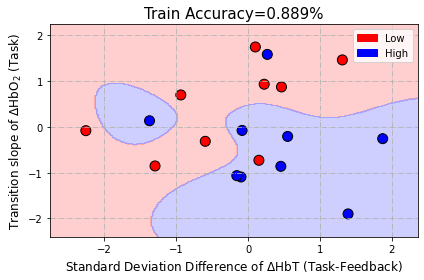

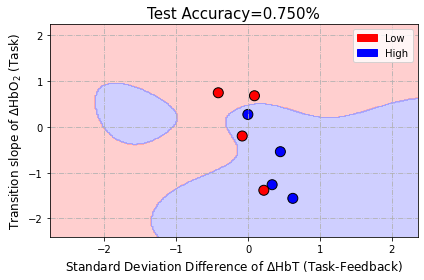

In [37]:
train_accuracy = accuracy_score(y_train, y_predict_train)
test_accuracy = accuracy_score(y_test, y_predict)
cm_light = mpl.colors.ListedColormap(['#FFA0A0', '#A0A0FF'])
cm_dark = mpl.colors.ListedColormap(['r', 'b'])

## Train
fig, ax = plt.subplots()
x0 = X_train_std[:, 0]
x1 = X_train_std[:, 1]

xx, yy = make_meshgrid(x0, x1)
plot_contours(ax, clf, xx, yy, cmap = cm_light, alpha = 0.5)     #設PCA圖背景顏色

ax.scatter(x0, x1, c = y_train, cmap = cm_dark, s = 100, edgecolors = 'k')
patch0 = mpatches.Patch(color='#FF0000', label='Low')
patch1 = mpatches.Patch(color='#0000FF', label='High')
plt.legend(handles=[patch0, patch1])
ax.set_xlabel('Standard Deviation Difference of $\Delta$HbT (Task-Feedback)', fontsize = 12)
ax.set_ylabel('Transition slope of $\Delta$HbO$_2$ (Task)', fontsize = 12)
ax.grid(True, linestyle = '-.')
ax.set_title(f'Train Accuracy={train_accuracy:.3f}%', size = 15)
plt.tight_layout()
plt.show()

#test
fig, ax = plt.subplots()
x2 = X_test_std[:, 0]
x3 = X_test_std[:, 1]

# xx, yy = make_meshgrid(x2, x3)
plot_contours(ax, clf, xx, yy, cmap = cm_light, alpha = 0.5)     #設PCA圖背景顏色

ax.scatter(x2, x3, c = y_test, cmap = cm_dark, s = 100, edgecolors = 'k')
patch0 = mpatches.Patch(color='#FF0000', label='Low')
patch1 = mpatches.Patch(color='#0000FF', label='High')
plt.legend(handles=[patch0, patch1])
ax.set_xlabel('Standard Deviation Difference of $\Delta$HbT (Task-Feedback)', fontsize = 12)
ax.set_ylabel('Transition slope of $\Delta$HbO$_2$ (Task)', fontsize = 12)
ax.grid(True, linestyle = '-.')
ax.set_title(f'Test Accuracy={test_accuracy:.3f}%', size = 15)
plt.tight_layout()
plt.show()


# Confusion matrix

In [15]:
def plot_confusion_matrix(cm, classes, title, normalize = False, cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print('\nNormalized confusion matrix:')
    else:
        print('\nUnnormalized confusion matrix:')
    print(cm)
    
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar(shrink = .92)     #使colorbar長度變為原來的92%
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 10)
    plt.yticks(tick_marks, classes, rotation = 90, fontsize = 10)
    
    fmt = '.2f' if normalize else 'd'
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = 'center', color = 'white' if cm[i, j] > 0.5 else 'black')
        #設定confusion matrix中數字顏色(過0.5變為黑色)   
        plt.xlabel('Predicted label', size = 10)
        plt.ylabel('True label', size = 10)
        plt.tight_layout()     
        #plt.tight_layout:自動調整繪圖區的大小及間距


Normalized confusion matrix:
[[0.5 0.5]
 [0.  1. ]]


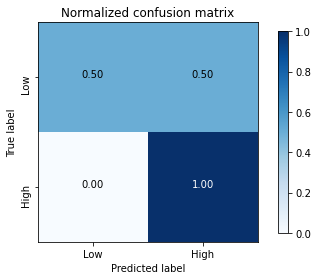

In [17]:
matrix = confusion_matrix(y_test, clf.predict(X_test_std))    
target = ['Low', 'High']

plot_confusion_matrix(matrix, classes = target, title = 'Normalized confusion matrix', normalize = True )

# Box plot

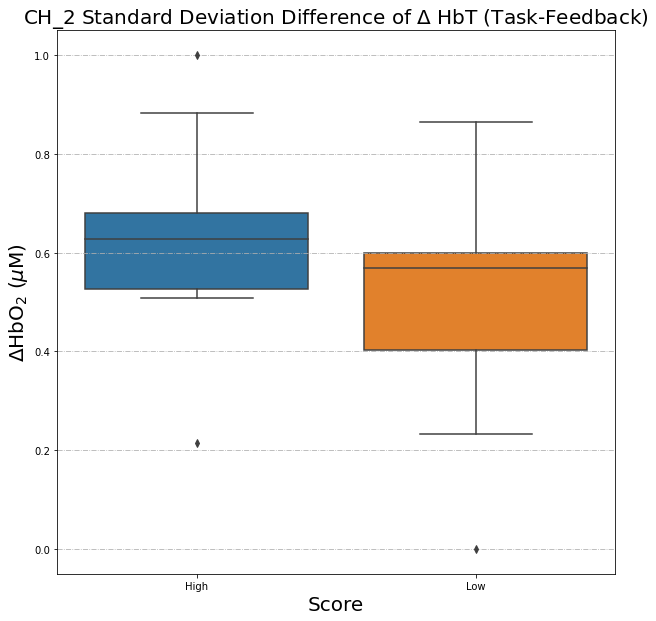

In [7]:
All_data = pd.concat([H_data, L_data], axis=0)
All_data['Label'] = All_data['Label'].map({1:'High', 0:'Low'})
feature = All_data['CH2_HbT_Trail_Feedback_Std_Diff']
# feature = All_data['CH3_HbT_Trail_Feedback_Std_Diff']
# feature = All_data['CH2_Oxy_Trail_Slope']
# feature = All_data['CH3_Oxy_Trail_Slope']
feature = (feature - feature.min())/(feature.max() - feature.min())
label = All_data['Label']
Data = pd.concat([feature, label], axis=1)
plt.figure(figsize=(10, 10))
plt.grid(True, linestyle = '-.')
sns.boxplot(data=Data, x='Label', y='CH2_HbT_Trail_Feedback_Std_Diff')
# sns.boxplot(data=Data, x='Label', y='CH3_Oxy_Trail_Slope')
plt.title('CH_2 Standard Deviation Difference of $\Delta$ HbT (Task-Feedback)',fontsize=20) 
# plt.title('CH_3 Transition slope of $\Delta$HbO$_2$ (Task)',fontsize=20) 
plt.xlabel('Score',fontsize=20)
# plt.ylabel('$\Delta$HbT ($\mu$M)',fontsize=20)
plt.ylabel('$\Delta$HbO$_2$ ($\mu$M)',fontsize=20)
plt.show()